### Always to run stuff

In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/amir/rqc_internship/frame_stack


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as jn
import os
import yaml
import torch
from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset


In [3]:
from video_pipeline.video_module import *

In [4]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)
with open('pathes.yaml') as conf_file:
    path_config = yaml.safe_load(conf_file)

pressure_path = path_config['p_video_path']
signal_path = path_config['s_video_path']


In [5]:

input_path = path_config['s_video_path']
output_path = path_config['p_video_path']

tr = config['video_train']
frames_number, frames_interval = tr["frames_number"], tr["frames_interval"]

# test_dataset = Stack_dataset(jn(output_path, 'test'), jn(input_path, 'test'), frames_number,
#                              frames_interval)
# train_dataset = Stack_dataset(jn(output_path, 'train'), jn(input_path, 'train'), frames_number,
#                               frames_interval)

def get_elemenst_from_dataset(slice, key_id=10):
    pressure_path, signal_path = jn(output_path, 'test'), jn(input_path, 'test')
    name = "test.hdf5"
    # i = 50

    with h5py.File(jn(signal_path, name)) as signal_file, \
            h5py.File(jn(pressure_path, name)) as pres_file:
            key = list(signal_file.keys())[key_id]
                # for key in tqdm(signal_file.keys(), dynamic_ncols=True, position=1, leave=False):

            signal = (signal_file[key][slice].astype(np.float32))
            pressure = (pres_file[key][slice].astype(np.float32))
    return pressure, signal

In [6]:
import torch_sensor_lib as tsl
sim = tsl.FiberSimulator(config)
import torch_real_sim_lib as trsl
new_sim = trsl.FiberSimulator(config)

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time 

### Клетка для запуска.

### End of always run stuff.
### Beginning of usful optional code.

### comparing predictions

In [8]:
import torch_bimodal_sim_lib as tbsl
simb = tbsl.FiberSimulator(config)

In [9]:

if not torch.cuda.is_available():
    print('CUDA is NOT available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# %%
tr = config['video_train']

CUDA is NOT available.  Training on CPU ...


In [10]:

signal_shape, pressure_shape = (1, 4, 64), (64, 64)
print('input chain shape: ', signal_shape, '\noutput chain shape: ',
      pressure_shape)

model_name = tr['model_name']
from video_pipeline import models_src

model_class = eval(f"models_src.{model_name}")

args = []
if model_name.startswith("Param"):
    layers = tr['layers']
    args.append(layers)
args.append(frames_number)
args.append(frames_interval)
model = model_class(pressure_shape[-2:], signal_shape[-2:], *args)
model = model.to(device)

print(model)

input chain shape:  (1, 4, 64) 
output chain shape:  (64, 64)
ParamUnet(
  (step1): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
  )
  (finalConv): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1), padding=same)
  )
  (bottom): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU()
      (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (5): ReLU()
    )
    (1): Sequential(
   

In [11]:
# loading data
pressure, signal = get_elemenst_from_dataset(slice(300), key_id=100)
# plt.imshow(pressure[0])
# plt.show()

In [12]:
checkpoint = torch.load("data/365_id_model.pt",
                     map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval();

#### Закончил играться. Теперь делаю нормальную функцию.

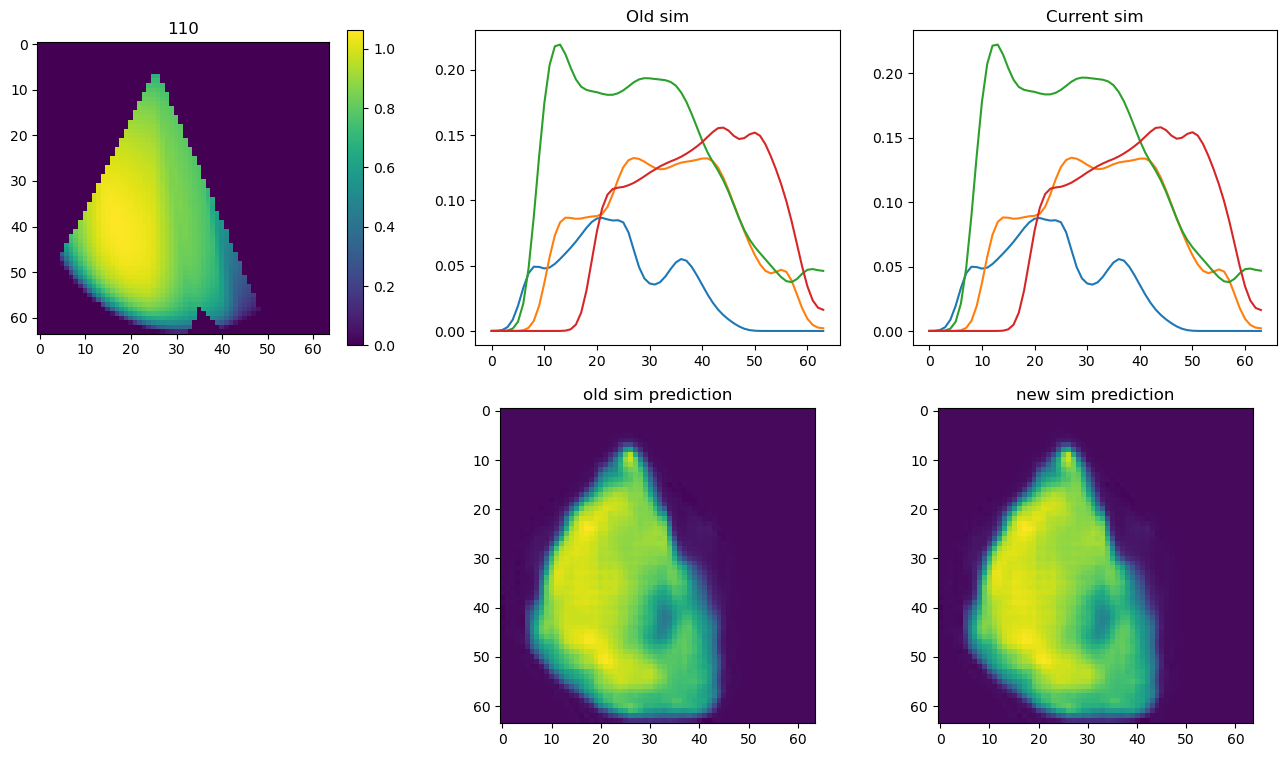

In [13]:

for i in range(110, 115, 5):
    clear_output(wait=True)
    plt.figure(figsize=(16, 9))
    plt.subplot(2, 3, 1)
    plt.imshow(pressure[i])
    plt.title(f"{i}")
    plt.colorbar()
    
    plt.subplot(2, 3, 2)
    plt.plot(signal[i].T)
    plt.title("Old sim")
    
    plt.subplot(2, 3, 3)
    new_signal = sim.fiber_real_sim(pressure[i])
    plt.plot(new_signal[0].T)
    plt.title("Current sim")
    
    plt.subplot(2, 3, 5)
    map = predict(model, signal[i:i+1], device)
    plt.imshow(map[0])
    plt.title("old sim prediction")
    
    plt.subplot(2, 3, 6)
    map = predict(model, new_signal, device)
    plt.imshow(map[0])
    plt.title("new sim prediction")
    
    plt.show()
    time.sleep(0.5)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms.functional import rotate as torch_rotate
from torchvision.transforms.functional import gaussian_blur

In [15]:
i = 110
pressure_mat = pressure[i:i+2]
self = simb
if not isinstance(pressure_mat, torch.Tensor):
    pressure_mat = torch.tensor(pressure_mat, device=self.device)

rot_tensor = self._rotate(pressure_mat)

blurred_mat = gaussian_blur(rot_tensor, self.gaus_kernel_size, self.gaus_sigma_pix)


In [16]:
blurred_mat.shape

torch.Size([8, 1, 64, 64])

In [17]:
curvatures = self._second_derivative(blurred_mat)
curvatures.shape

torch.Size([8, 1, 62, 64])

### Эксперименты с разными способами вычисления. Сравнения времен.

сравним время работы фстроенного умножения с циклом for

In [18]:
%%timeit
res = torch.prod(curvatures, dim=-2)
# print(res.shape)

18.6 µs ± 2.6 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [19]:
%%timeit
res = curvatures[:, :, 0]
for i in range(1, curvatures.shape[2]):
    res*=curvatures[:, :, i]
# print(res[0, 0, 32])

452 µs ± 93.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


20 раз. Дофига большое отличие. Нельзя так долго считать.

In [20]:
# %%timeit
# res = np.prod(curvatures, axis=-2)
# # print(res.shape)

In [21]:
%%timeit
res = np.prod(curvatures.numpy(), axis=-2)
# res.shape

25.7 µs ± 738 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


можно нумпаем обойтись в крайнем случае

In [22]:
list(curvatures.shape[0:-2]) + [2, 2]+ list(curvatures.shape[-1:])

[8, 1, 2, 2, 64]

In [23]:
%%timeit
# пытаюсь моделировать создание матриц
res = np.zeros(list(curvatures.shape[0:-2]) + [2, 2] + list(curvatures.shape[-1:]))
res[..., 0, 0, :] = curvatures.numpy()[..., 0, :]


6.05 µs ± 974 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


ищю функцию для перемножения многих массивов

In [24]:
a = np.array([[1, 4], [3, 1]])
np.linalg.multi_dot([a, 2*a, a*a])

array([[170, 432],
       [246, 218]])

In [25]:
b = np.array([a, 2*a, a*a])
print(b.shape)
np.linalg.multi_dot(b)

(3, 2, 2)


array([[170, 432],
       [246, 218]])

In [26]:
# b = np.array([[a, 2*a, a*a]])
# print(b.shape)
# np.linalg.multi_dot(b)

# # ValueError: Expecting at least two arrays

In [27]:
c = np.array([torch.tensor([1, 2, 3, 4]), torch.tensor([1, 2, 3, 4]), torch.tensor([1, 2, 3, 4]), torch.tensor([1, 2, 3, 4])]).reshape(2, 2)
print(c.shape)
d = c@c
print(d)
print(d.shape)

(2, 2)
[[tensor([ 2,  8, 18, 32]) tensor([ 2,  8, 18, 32])]
 [tensor([ 2,  8, 18, 32]) tensor([ 2,  8, 18, 32])]]
(2, 2)


/tmp/ipykernel_125586/3355885926.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  c = np.array([torch.tensor([1, 2, 3, 4]), torch.tensor([1, 2, 3, 4]), torch.tensor([1, 2, 3, 4]), torch.tensor([1, 2, 3, 4])]).reshape(2, 2)
/tmp/ipykernel_125586/3355885926.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array([torch.tensor([1, 2, 3, 4]), torch.tensor([1

In [28]:
# b = np.array([a, 2*a, a*a]).reshape(3, 2, 2, 1)
# print(b.shape)
# np.linalg.multi_dot(b)

# # LinAlgError: 3-dimensional array given. Array must be two-dimensional


Все придумал. Только придется разделить на отдельные массивы все 62 среза.

In [29]:
array_of_matrixes = np.zeros((62, 2, 2), dtype=torch.Tensor)        # (64, 2, 2), contains big arrays, that will be element-wise multipiled

In [30]:
for i in range(62):
    array_of_matrixes[i, 0, 0] = torch.rand((8, 1, 64))
    array_of_matrixes[i, 0, 1] = torch.rand((8, 1, 64))
    array_of_matrixes[i, 1, 0] = torch.rand((8, 1, 64))
    array_of_matrixes[i, 1, 1] = torch.rand((8, 1, 64))

array_of_matrixes[k, 0, 0] = function with coefficient for 1,1(curvatures[...(8, 1), k, :(64)])

In [31]:
result_matrixes = np.linalg.multi_dot(array_of_matrixes)
print(result_matrixes[0, 0].shape)
result_matrixes.shape

torch.Size([8, 1, 64])


(2, 2)

In [32]:
vector1 = np.array([1, 1]).reshape(2)
vector2 = np.array([1, 1]).reshape(2)
result_numbers = vector1@result_matrixes@vector2
# result_numbers = np.dot(vector1, (result_matrixes@vector2))
print(result_numbers.shape)

torch.Size([8, 1, 64])


То, что нужно.

In [33]:
%%timeit
result_matrixes = np.linalg.multi_dot(array_of_matrixes)
result_matrixes.shape
result_numbers = vector1@result_matrixes@vector2
# result_numbers = np.dot(vector1, (result_matrixes@vector2))

51.8 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
40.2/8/64*1000 # микросекунд

78.515625

получилось в 5 раз быстрее, чем просто питоном перебирать их.
Если на одну картинку 64на64 уходит 20 мс, в одном видео 300 картинок, 64 видео для примерно 300 предметов.

In [35]:
0.02*300*64*300/60/60 #часы

32.0

То есть 32 будет считаться на моем ноуте. Думаю на сервере может за пару часов посчитаться.

### компиляция полученного в функции

In [36]:
interfere_period = 2.3  # период интерференции в мм.
self.dk = 2*np.pi/interfere_period    # разница волновых векторов между модами.
c11 = 1
c21 = 0.2
c12 = 0.1
c22 = 1
C = np.array(
    [[1, 0.2],
     [0.1, 1]]
)
print(C)
# константы, отвечающие за коэффициенты в матрице преобразования


[[1.  0.2]
 [0.1 1. ]]


In [37]:
loss_funcs = [
    # [lambda x, i=i, j=j: self.pixel_distance*C[i][j]*x**2 for j in range(2)]
    [lambda x, i=i, j=j: 0.35*C[i][j]*x**2 for j in range(2)]
    # [lambda x: C[i][j]*x**2 for j in range(2)]
    # [lambda x: 0.1*x**2 for j in range(2)]
    for i in range(2)
]
print(loss_funcs[0][1](1), C[0][1])

0.06999999999999999 0.2


In [38]:
for i in range(2):
    for j in range(2):
        print(loss_funcs[i][j](1)/self.pixel_distance, C[i][j])

1.0 1.0
0.19999999999999998 0.2
0.09999999999999999 0.1
1.0 1.0


Пишем по сути поведение функции sum_fiber_losses(curvature)

In [39]:
array_of_matrixes = np.zeros((curvatures.shape[-2], 2, 2), dtype=torch.Tensor)# (62, 2, 2), contains big tensors (n_angles*n_pictures, 1, 64), that will be element-wise multipiled

In [40]:
I = torch.view_as_complex(torch.Tensor([0, 1.]))

torch.exp(I*np.pi)

tensor(-1.-8.7423e-08j)

In [41]:
for i in range(curvatures.shape[-2]):
    array_of_matrixes[i, 0, 0] = 1 - loss_funcs[0][0](curvatures[..., i, :])
    array_of_matrixes[i, 0, 1] = loss_funcs[0][1](curvatures[..., i, :])
    array_of_matrixes[i, 1, 0] = loss_funcs[1][0](curvatures[..., i, :])
    array_of_matrixes[i, 1, 1] = (1 - loss_funcs[1][1](curvatures[..., i, :]))*torch.exp(I*self.pixel_distance*self.dk)

array_of_matrixes[k, 0, 0] = function with coefficient for 1,1(curvatures[...(8, 1), k, :(64)])

In [42]:
result_matrixes = np.linalg.multi_dot(array_of_matrixes)
print(result_matrixes[0, 0].shape)
result_matrixes.shape

torch.Size([8, 1, 64])


(2, 2)

In [43]:
vector1 = np.array([1, 0.2]).reshape(2)     # in first taper amplitudes of HE11 and HE21 modes
vector2 = np.array([1, 0.2]).reshape(2)     
# in second taper imparts of amplitudes of HE11 and HE21 modes in waist for HE11 amplitude in
# fiber after taper.

result_numbers = vector2@result_matrixes@vector1
# result_numbers = np.dot(vector1, (result_matrixes@vector2))
print(result_numbers.shape)

torch.Size([8, 1, 64])


тестовый датасет из давлений
при расстоянии между пискелями 0.35 мм, чтобы покрыть несколько периодов = 2.3 мм нужно примерно 7*n клеточек.
Если в 10 раз увеличивать частоту точек, нужно 70*n. Возьмем n=2.5, тогда 180.
В ширину будет по 3 пискеля в каждую сторону, так что 65 сойдет.

In [62]:
self.pixel_distance = 0.35/10

In [63]:
test_dataset = np.zeros((180, 180, 65), dtype=np.float32)
for i in range(180):
    test_dataset[i, i, (65-1)//2] = 1
# test_dataset*=(10**2)

In [64]:
pressure_mat = np.expand_dims(test_dataset, axis=-3)
if not isinstance(pressure_mat, torch.Tensor):
    pressure_mat = torch.tensor(pressure_mat, device=self.device)

rot_tensor = pressure_mat

blurred_mat = gaussian_blur(rot_tensor, self.gaus_kernel_size, self.gaus_sigma_pix)

curvatures = self._second_derivative(blurred_mat)
curvatures.shape

torch.Size([180, 1, 178, 65])

### строю для одной амплитуды картину периодического эффекта

In [48]:
15*0.35**4  ## это множитель потерь при квадрате кривизны в старой симуляции.

0.22509374999999995

In [65]:
interfere_period = 2.3  # период интерференции в мм.
self.dk = 2*np.pi/interfere_period    # разница волновых векторов между модами.
c11 = 1
c21 = 0.2
c12 = 0.1
c22 = 1
C = np.array(
    [[1, 0.2],
     [0.1, 1]]
)
print(C)
# константы, отвечающие за коэффициенты в матрице преобразования


[[1.  0.2]
 [0.1 1. ]]


In [66]:
loss_funcs = [
    [lambda x, i=i, j=j: 0.225*self.pixel_distance*C[i][j]*x**2 for j in range(2)]
    for i in range(2)
]
print(loss_funcs[0][1](1), C[0][1])

0.001575 0.2


In [67]:
I = torch.view_as_complex(torch.Tensor([0, 1.]))

torch.exp(I*np.pi)

tensor(-1.-8.7423e-08j)

In [68]:
array_of_matrixes = np.zeros((curvatures.shape[-2], 2, 2), dtype=torch.Tensor)# (62, 2, 2), contains big tensors (n_angles*n_pictures, 1, 64), that will be element-wise multipiled

for i in range(curvatures.shape[-2]):
    array_of_matrixes[i, 0, 0] = 1 - loss_funcs[0][0](curvatures[..., i, :])
    array_of_matrixes[i, 0, 1] = loss_funcs[0][1](curvatures[..., i, :])
    array_of_matrixes[i, 1, 0] = loss_funcs[1][0](curvatures[..., i, :])
    array_of_matrixes[i, 1, 1] = (1 - loss_funcs[1][1](curvatures[..., i, :]))*torch.exp(I*self.pixel_distance*self.dk)

result_matrixes = np.linalg.multi_dot(array_of_matrixes)

vector1 = np.array([1, 0.2]).reshape(2)     # in first taper amplitudes of HE11 and HE21 modes
vector2 = np.array([1, 0.2]).reshape(2)     
# in second taper imparts of amplitudes of HE11 and HE21 modes in waist for HE11 amplitude in
# fiber after taper.

result_numbers = (vector2@result_matrixes@vector1).abs()
# result_numbers = np.dot(vector1, (result_matrixes@vector2))
print(result_numbers.shape)

torch.Size([180, 1, 65])


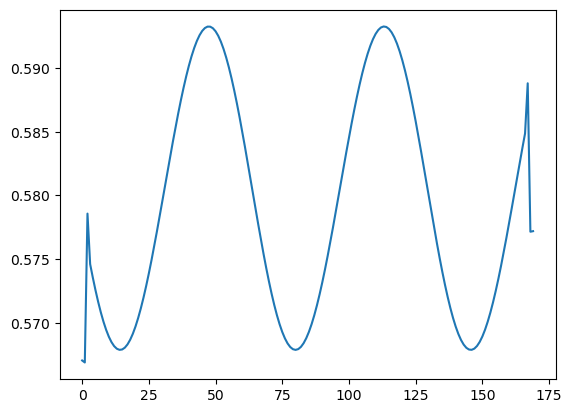

In [69]:
array = result_numbers[5:-5, 0, (65-1)//2]
plt.plot(array)

То, что доктор прописал. Так и надо.

На одну картинку 180 на 65 в среднем 7 мс. Меньше, чем по старым оценкам для картинки 64 на 64. Видимо с увеличением данных среднее время упало

In [54]:
1400/180

7.777777777777778

Строю то же самое для разных амплитуд.

In [55]:
self.pixel_distance = 0.35/10

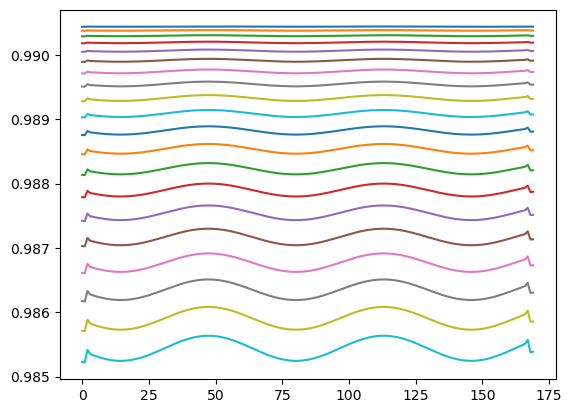

In [56]:
amps = np.linspace(1e-4, 1e-3, 20)
result_array = np.zeros((len(amps), 180))
for j, amplitude in enumerate(amps):
        
    pressure_mat = np.expand_dims(test_dataset*amplitude, axis=-3)
    if not isinstance(pressure_mat, torch.Tensor):
        pressure_mat = torch.tensor(pressure_mat, device=self.device)

    rot_tensor = pressure_mat

    blurred_mat = gaussian_blur(rot_tensor, self.gaus_kernel_size, self.gaus_sigma_pix)

    curvatures = self._second_derivative(blurred_mat)
    curvatures.shape


    array_of_matrixes = np.zeros((curvatures.shape[-2], 2, 2), dtype=torch.Tensor)# (62, 2, 2), contains big tensors (n_angles*n_pictures, 1, 64), that will be element-wise multipiled

    for i in range(curvatures.shape[-2]):
        array_of_matrixes[i, 0, 0] = 1 - loss_funcs[0][0](curvatures[..., i, :])
        array_of_matrixes[i, 0, 1] = loss_funcs[0][1](curvatures[..., i, :])
        array_of_matrixes[i, 1, 0] = loss_funcs[1][0](curvatures[..., i, :])
        array_of_matrixes[i, 1, 1] = (1 - loss_funcs[1][1](curvatures[..., i, :]))*torch.exp(I*self.pixel_distance*self.dk)

    result_matrixes = np.linalg.multi_dot(array_of_matrixes)

    vector1 = np.array([1, 0.2]).reshape(2)     # in first taper amplitudes of HE11 and HE21 modes
    vector2 = np.array([1, 0.2]).reshape(2)     
    # in second taper imparts of amplitudes of HE11 and HE21 modes in waist for HE11 amplitude in
    # fiber after taper.

    result_numbers = (vector2@result_matrixes@vector1).abs()
    # result_numbers = np.dot(vector1, (result_matrixes@vector2))
    # print(result_numbers.shape)
    array = result_numbers[5:-5, 0, (65-1)//2]
    result_array[j] = result_numbers[:, 0, (65-1)//2]
    plt.plot(array)
    

Ура, работает. Теперь пытаюсь найти оптимальные амплитуды

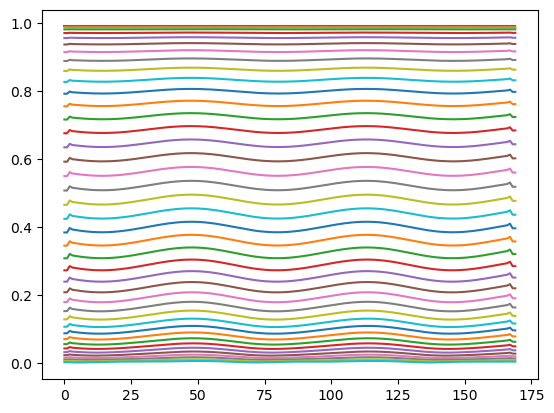

In [57]:
amps = np.linspace(1e-6, 2.5e-2, 40)
result_array = np.zeros((len(amps), 180))
for j, amplitude in enumerate(amps):
        
    pressure_mat = np.expand_dims(test_dataset*amplitude, axis=-3)
    if not isinstance(pressure_mat, torch.Tensor):
        pressure_mat = torch.tensor(pressure_mat, device=self.device)

    rot_tensor = pressure_mat

    blurred_mat = gaussian_blur(rot_tensor, self.gaus_kernel_size, self.gaus_sigma_pix)

    curvatures = self._second_derivative(blurred_mat)
    curvatures.shape


    array_of_matrixes = np.zeros((curvatures.shape[-2], 2, 2), dtype=torch.Tensor)# (62, 2, 2), contains big tensors (n_angles*n_pictures, 1, 64), that will be element-wise multipiled

    for i in range(curvatures.shape[-2]):
        array_of_matrixes[i, 0, 0] = 1 - loss_funcs[0][0](curvatures[..., i, :])
        array_of_matrixes[i, 0, 1] = loss_funcs[0][1](curvatures[..., i, :])
        array_of_matrixes[i, 1, 0] = loss_funcs[1][0](curvatures[..., i, :])
        array_of_matrixes[i, 1, 1] = (1 - loss_funcs[1][1](curvatures[..., i, :]))*torch.exp(I*self.pixel_distance*self.dk)

    result_matrixes = np.linalg.multi_dot(array_of_matrixes)

    vector1 = np.array([1, 0.2]).reshape(2)     # in first taper amplitudes of HE11 and HE21 modes
    vector2 = np.array([1, 0.2]).reshape(2)     
    # in second taper imparts of amplitudes of HE11 and HE21 modes in waist for HE11 amplitude in
    # fiber after taper.

    result_numbers = (vector2@result_matrixes@vector1).abs()
    # result_numbers = np.dot(vector1, (result_matrixes@vector2))
    # print(result_numbers.shape)
    array = result_numbers[5:-5, 0, (65-1)//2]
    result_array[j] = result_numbers[:, 0, (65-1)//2]
    plt.plot(array)
    

Строю зависимость амплитуды синусойды от пропускания

/home/amir/anaconda3/envs/rqc_env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


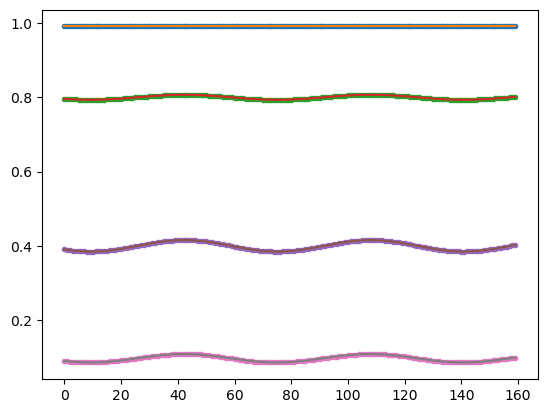

In [58]:
Asin = np.zeros_like(amps)
main_signal = np.zeros_like(amps)

def sinus(x, w, phi, A, C):
    return np.sin(x*w + phi)*A + C

from scipy.optimize import curve_fit

for j in range(len(amps)):
    signal = result_array[j][10:-10]
    popt, pcov = curve_fit(sinus, np.arange(len(signal)), signal, p0=[2*np.pi/(80), 2.5, 0.05, np.mean(signal)])
    Asin[j] = popt[2]
    main_signal[j] = popt[3]
    
    if j%10 == 0:
        plt.plot(signal, ".")
        plt.plot(sinus(np.arange(len(signal)), *popt))


Text(0.5, 1.0, 'Зависимость для симуляции двух мод')

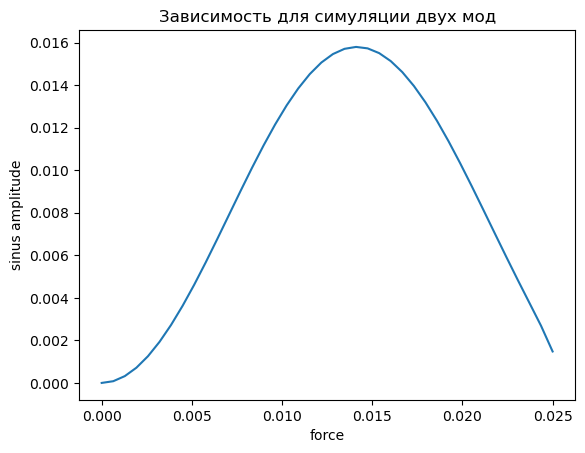

In [59]:
plt.plot(amps, np.abs(Asin))
plt.xlabel("force")
plt.ylabel("sinus amplitude")
plt.title("Зависимость для симуляции двух мод")
# plt.savefig("sinAmpl_sim.jpg")

# Переделываю функции в модуль.

### Код для тестирования

In [131]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)

In [132]:
import torch_bimodal_sim_lib as tbsl
config["env"]["sen_geometry"]["distance"] = 0.35/10
config["env"]["sen_geometry"]["n_angles"] = 1
config["env"]["phys"]["sigma"] = 0.8/10

simb = tbsl.FiberSimulator(config)
config["env"]["phys"]["sigma"] = 0.8
config["env"]["sen_geometry"]["distance"] = 0.35

In [133]:
test_dataset = np.zeros((180, 180, 65), dtype=np.float32)
for i in range(180):
    test_dataset[i, i, (65-1)//2] = 1

pressure_mat = np.expand_dims(test_dataset*amplitude, axis=-3)

In [134]:
pressure_mat.shape

(180, 1, 180, 65)

In [135]:
result_numbers = simb.fiber_real_sim(test_dataset)
new_sim_signal = result_numbers

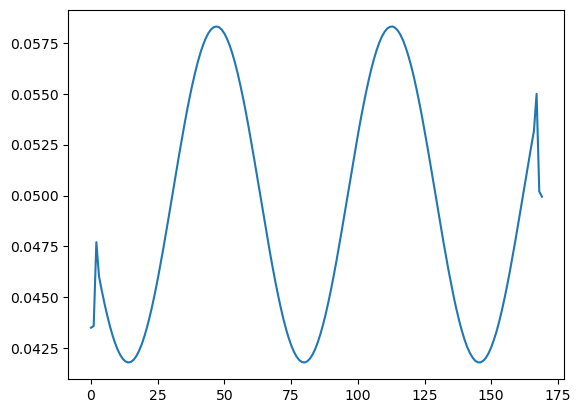

In [136]:
array = result_numbers[5:-5, 0, (65-1)//2]
plt.plot(array)

А теперь сравнение того же с симуляцией старой.

In [137]:
import torch_sensor_lib as tsl
config["env"]["sen_geometry"]["distance"] = 0.35/10
config["env"]["sen_geometry"]["n_angles"] = 1
config["env"]["phys"]["sigma"] = 0.8/10

sim = tsl.FiberSimulator(config)
config["env"]["phys"]["sigma"] = 0.8
config["env"]["sen_geometry"]["distance"] = 0.35

In [138]:
test_dataset = np.zeros((180, 180, 65), dtype=np.float32)
for i in range(180):
    test_dataset[i, i, (65-1)//2] = 1

pressure_mat = np.expand_dims(test_dataset*amplitude, axis=-3)

In [139]:
result_numbers = sim.fiber_real_sim(test_dataset)

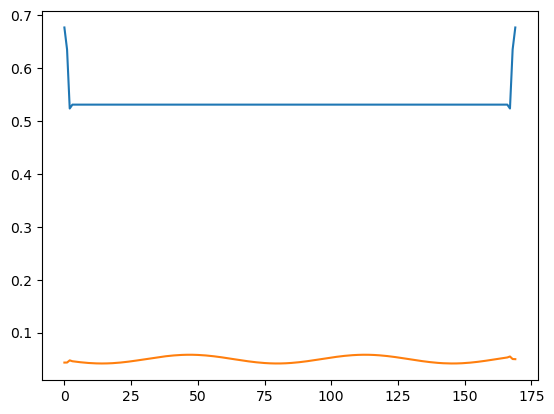

In [140]:
array = result_numbers[5:-5, 0, (65-1)//2]
plt.plot(array)
plt.plot(new_sim_signal[5:-5, 0, (65-1)//2])

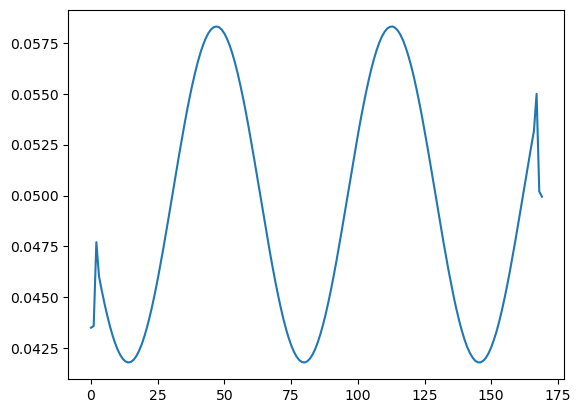

In [141]:
plt.plot(new_sim_signal[5:-5, 0, (65-1)//2])

###  Подбираю правильный главный коэффициент в новой симуляции

In [46]:
with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)

In [64]:
l = 4   # длина в мм
N = 256 # количество точек
fiber_dist = l/N

config['env']['sen_geometry']['distance'] =  fiber_dist
config['env']['sen_geometry']['n_angles'] =  1
config['env']['bimodal']['intermode_matrix'] = \
    [[1, 0],
      [0, 0]]

In [39]:
point_pres = torch.zeros((N, N))
point_pres[N//2, N//2] = 1/fiber_dist**2/270

In [65]:
import torch_bimodal_sim_lib as tbsl
simb = tbsl.FiberSimulator(config)
import torch_sensor_lib as tsl
sim = tsl.FiberSimulator(config)

Rot tensors


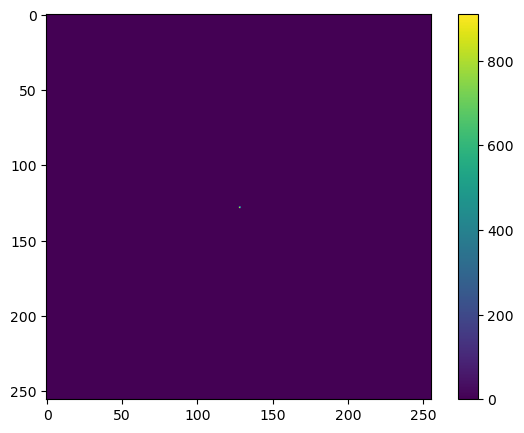

After blur


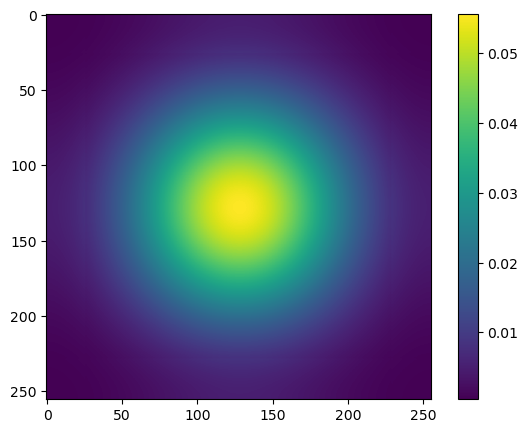

Loss in fiber


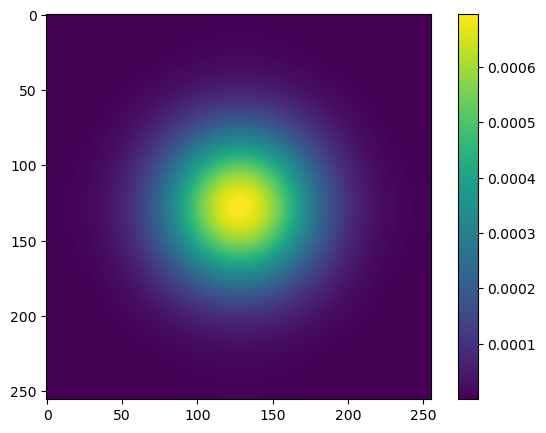

Loss sums


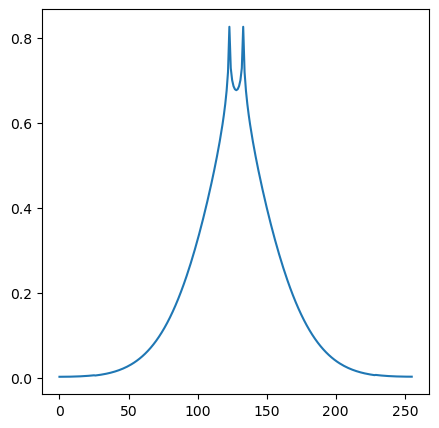

Signal


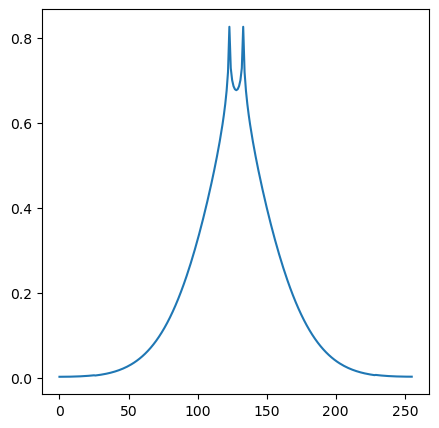

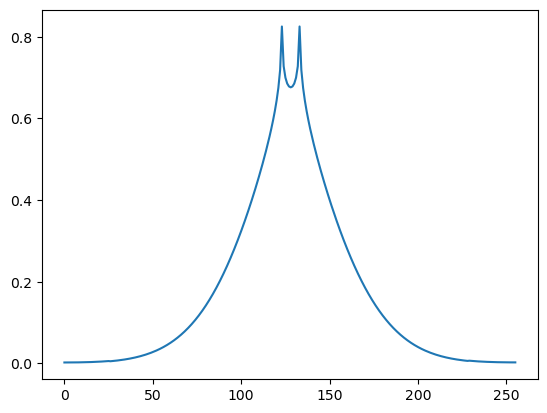

In [56]:
# amps = np.linspace(0, 60, 200)
amps = np.linspace(0, 60, 20)
amps = np.linspace(60, 60, 1)
result_array = np.zeros((len(amps), N))
sim.test = True
for amplitude in amps:
    signal = sim.fiber_real_sim(point_pres*amplitude)[0]
    plt.plot(signal.T)
sim.test = False

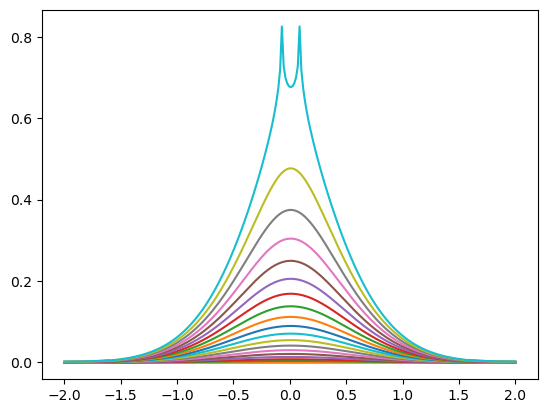

In [42]:
# amps = np.linspace(0, 60, 200)
amps = np.linspace(1, 60, 20)
# amps = np.linspace(1, 60, 20)*(N/64)**2
result_array = np.zeros((len(amps), N))
sim.test = False
for i, amplitude in enumerate(amps):
    signal = sim.fiber_real_sim(point_pres*amplitude)[0]
    result_array[i] = signal[0]
plt.plot(np.linspace(-l/2, l/2, N), result_array.T);

Теперь точечные кривые

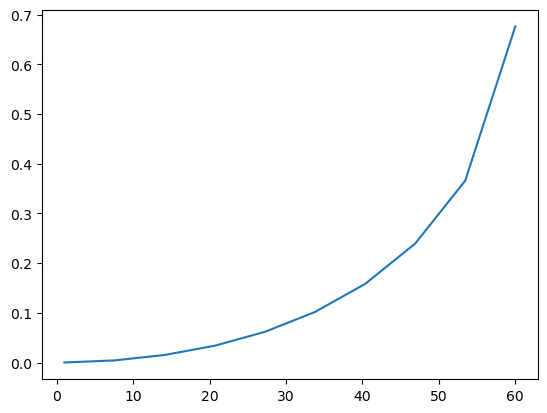

In [57]:
# amps = np.linspace(0, 60, 200)
amps = np.linspace(1, 60, 10)
sensetive = np.zeros_like(amps)
# result_array = np.zeros((len(amps), N))
sim.test = False
for i, amplitude in enumerate(amps):
    signal = sim.fiber_real_sim(point_pres*amplitude)[0]
    # result_array[i] = signal[0]
    sensetive[i] = signal[0][N//2]
plt.plot(amps, sensetive);

In [67]:
simb.main_loss_coeff
# 0.225

0.225

In [101]:
simb.main_loss_coeff = 1.5

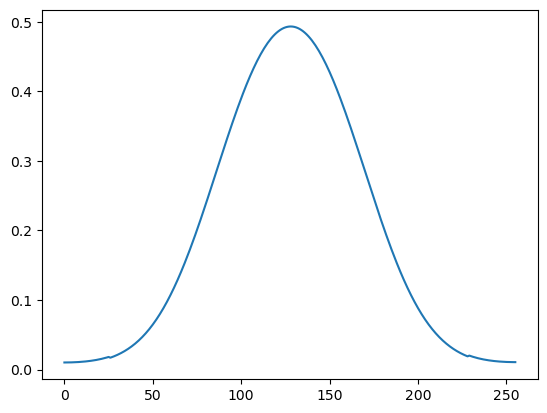

In [102]:
amps3 = np.linspace(60, 60, 1)
result_array = np.zeros((len(amps3), N))
sim.test = True
for amplitude in amps3:
    signal = simb.fiber_real_sim(point_pres*amplitude)[0]
    plt.plot(signal.T)
sim.test = False

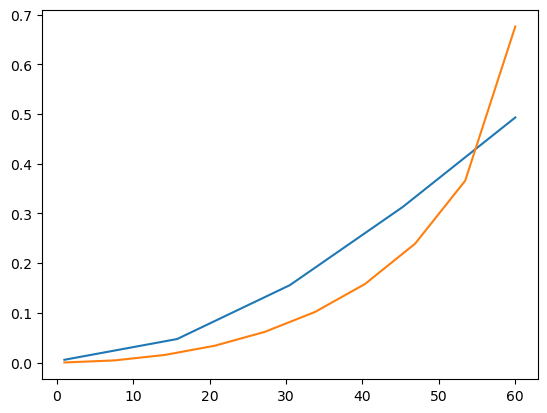

In [103]:
# новая симуляция
# amps = np.linspace(0, 60, 200)
amps2 = np.linspace(1, 60, 5)
sensetive2 = np.zeros_like(amps2)
# result_array = np.zeros((len(amps), N))
simb.test = False
for i, amplitude in enumerate(amps2):
    signal = simb.fiber_real_sim(point_pres*amplitude)[0]
    # result_array[i] = signal[0]
    sensetive2[i] = signal[0][N//2]
plt.plot(amps2, sensetive2);
plt.plot(amps, sensetive);

10 много, 5 много, 3 много, 2 много, 1.5 то много, то мало. Примерно то, что нужно.
